# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD4 - Régression linéaire

Ce TD concerne la régression linéaire (Chapitre 2 du cours). À la fin de ce TD, vous devriez être avoir été en mesure de :
- Choisir un modèle sur la base de l'estimation ou de la prédiction.
- Vérifier pour la présence de multicolinéarité.
- Transformer les variables pour modéliser des relations non-linéaires.


## Contexte : Poids des poissons

Le fichier *fishweights.csv* contient les caractéristiques de 158 poissons péchés dans le lac Laengelmavesi en Finlande. Nous étudierons le poids (Weight en grammes) des poissons en fonction de variables explicatives suivantes :
- l'espèce de poisson (species) ;
- la longueur standard (StandardLength) ;
- la longeur non standard  (NonStandardLength) ;
- la longueur totale (TotalLength) ;
- la hauteur (Height) ;
- la largeur (Width).


          ___/////___                  _
         /           \    ___          |
       /\             \_ /  /          H
     <   )            __)  \           |
       \/_\\_________/   \__\          _

     |------- SL -------|
     |------- NSL ---------|
     |------- TL ------------|

In [1]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
using Statistics

## Chargement des données

In [25]:
data = CSV.read("fishweights.csv", DataFrame)
first(data,10)

10×7 DataFrame
 Row │ Species   Weight   StandardLength  NonStandardLength  TotalLength  Heig ⋯
     │ String15  Float64  Float64         Float64            Float64      Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Brème       242.0            23.2               25.4         30.0     1 ⋯
   2 │ Brème       290.0            24.0               26.3         31.2     1
   3 │ Brème       340.0            23.9               26.5         31.1     1
   4 │ Brème       363.0            26.3               29.0         33.5     1
   5 │ Brème       430.0            26.5               29.0         34.0     1 ⋯
   6 │ Brème       450.0            26.8               29.7         34.7     1
   7 │ Brème       500.0            26.8               29.7         34.5     1
   8 │ Brème       390.0            27.6               30.0         35.0     1
   9 │ Brème       450.0            27.6               30.0         35.1     1 ⋯
  10 │ Brème       500.0            28.5               30.7         36.2     1
                                                               2 columns omitted

# Exercice 1 - Analyse exploratoire

## a) Illustrez les poids en fonction des espèces de poisson

**Note :** Avec Gadfly, la variable *x* peut être une variable catégorielle.

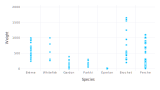

In [26]:
plot(data, x=:Species, y=:Weight, Geom.point)

## b) Illustrez les poids en fonction de la longeur standard et des espèces.

**Suggestion :** Utilisez l'option *color* de Gadfly pour distinguer les différentes espèces.

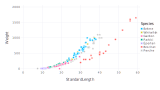

In [27]:
plot(data, x=:StandardLength, y=:Weight, color=:Species, Geom.point)

## c) Calculez le poids moyen pour chaque espèce ainsi que le nombre d'observations pour chaque espèce.

Les fonctions `combine()` et `groupby()` permettent d'effectuer rapidement ces tâches. Puisqu'elles ne sont pas intuitives, je vous donne d'emblée la réponse. C'est une combinaison de commandes qui pourra vous être utile dans tout le cours.

In [28]:
df = combine(groupby(data, :Species), :Weight => mean => :Weight, :Weight => length => :n)

7×3 DataFrame
 Row │ Species    Weight    n     
     │ String15   Float64   Int64 
─────┼────────────────────────────
   1 │ Brème      626.0        34
   2 │ Whitefish  531.0         6
   3 │ Gardon     152.05       20
   4 │ Parkki     154.818      11
   5 │ Éperlan     11.1786     14
   6 │ Brochet    718.706      17
   7 │ Perche     382.239      56

# Exercice 2 - Ajustement *vs* prédiction

Dans cet excercice, on considère le **poids** des éperlans en fonction de la **longueur standard**. On utilisera un ensemble d'entraînement ainsi qu'un ensemble de validation pour évaluer l'erreur de prédiction sur des données non utilisées pour l'estimation des paramètres.

In [29]:
"""
    construct_structure(x::Vector{<:Real}, order::Int)

Construction de la matrice de structure du modèle polynomial d'ordre `order` à partir du vecteur `x`.
"""
function construct_structure(x::Vector{<:Real}, order::Int)
    
    X = Array{Float64}(undef, length(x), order+1)
    
    for p in 0:order
       X[:,p+1] = x.^p 
    end
    
    return X
    
end

construct_structure

## a) Construction de l'ensemble d'entraînement et de validation pour les éperlans

In [30]:
eperlan = filter(row -> row.Species == "Éperlan", data)
train = eperlan[1:2:end, :]   # On récupère une ligne sur deux (1, 3, 5, etc.) pour l'ens. d'entraînement 
validation = eperlan[2:2:end, :]; # On récupère une ligne sur deux (2, 4, 6, etc.) pour l'ens. de valid.

## b) Modèle linéaire

1. Estimez la droite de régression avec les données de l'ensemble d'entraînement.
2. Tracez la droite de régression ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Vous pouvez utilisez la fonction `layer()` de Gadfly pour ajouter plusieurs couches à un graphique ou vous pouvez aussi définir un nouveau DataFrame pour faciliter l'affichage avec Gadfly.

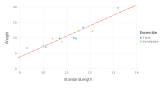

In [31]:
# Ajout d'une variable indicant à quelle ensemble appartient la donnée
eperlan[:, :Ensemble] .= "Train"
eperlan[2:2:end, :Ensemble] .= "Validation"

# Construction de la matrice de structure avec la fonction fournie
X = construct_structure(train.StandardLength, 1)

# Estimation des paramètres de l'hyperplan de régression sur les données d'entraînement
β̂ = X \ train.Weight

# Affichage des points et de la droite de régression
plot(eperlan, x=:StandardLength, y=:Weight, color=:Ensemble, Geom.point,
    intercept = [β̂[1]], slope = [β̂[2]], Geom.abline(color="red", style=:dash))

## c) Modèle cubique

1. Estimez les paramètres du modèle cubique en utilisant les données de l'ensemble d'entraînement.
2. Tracez la courbe donnée par le modèle ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Utilisez la fonction `construct_structure()` fournie pour construire la matrice de structure pour le modèle cubique avec `order=3`.

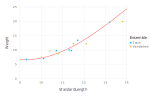

In [33]:
# Construction de la matrice de structure avec la fonction fournie
X = construct_structure(train.StandardLength, 3)

# Estimation des paramètres de l'hyperplan de régression sur les données d'entraînement
β̂ = X \ train.Weight

### Affichage de la droite de régression :
# Définition du vecteur des x pour afficher le modèle
xx = collect(range(9, stop=14, length=20))  # collect() pour construire un vecteur à partir d'un range

# Construction de la matrice de structure associée au vecteur xx
XX = construct_structure(xx, 3)

# Calcul des estimations associées à xx
yy = XX*β̂

# Affichage de la droite de régression
model = layer(x = xx, y = yy, Geom.line, Theme(default_color=colorant"red"))

### Affichage des points :
points = layer(eperlan, x=:StandardLength, y=:Weight, color=:Ensemble, Geom.point)

set_default_plot_size(15cm, 10cm)
plot(points, model, Guide.yticks())

## d) Modèle d'ordre 6

1. Estimez les paramètres du modèle d'ordre 6 en utilisant les données de l'ensemble d'entraînement.
2. Tracez la courbe donnée par le modèle ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Utilisez la fonction `construct_structure()` fournie pour construire la matrice de structure pour le modèle cubique avec `order=6`.

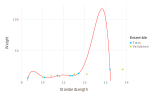

In [10]:
# Construction de la matrice de structure avec la fonction fournie
X = construct_structure(train.StandardLength, 6)

# Estimation des paramètres de l'hyperplan de régression sur les données d'entraînement
β̂ = X \ train.Weight

# Définition du vecteur des x pour afficher le modèle
xx = collect(9:0.01:14)

# Construction de la matrice de structure associée au vecteur xx
XX = construct_structure(xx, 6)

# Calcul des estimations associées à xx
yy = XX*β̂

# Affichage des points et de la droite de régression
points = layer(eperlan, x=:StandardLength, y=:Weight, color=:Ensemble, Geom.point)
model = layer(x = xx, y = yy, Geom.line, Theme(default_color=colorant"red"))

set_default_plot_size(15cm, 10cm)
plot(points, model, Coord.cartesian(ymin=5, ymax=120))

## e) Calcul de la qualité d'ajustement et de l'erreur de prédiction

Pour les modèles d'ordre 0 à 6, calculez 
- le coefficient de détermination
- le coefficient de détermination ajusté
- l'erreur quadratique moyenne (MSE) sur l'échantillon de validation.

**Suggestion :** Ajoutez une ligne au tableau `df` proposé pour chacun des ordre de modèle avec la fonction `push!()`.


In [11]:
df = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[])

# Variabilité totale
SST = sum( (train.Weight .- mean(train.Weight)).^2 )

for order in 1:6
    n = size(train,1)
    
    # Ajustement du modèle de régression polynomiale
    X = construct_structure(train.StandardLength, order)
    β̂  = X\train.Weight
    
    # Calcul de l'erreur
    ŷ = X*β̂
    e = train.Weight - ŷ
    
    # Calcul de la somme du carré des erreurs
    SSE = e'e
    
    # Calcul de l'erreur quadratique moyenne avec l'ensemble de validation
    X̃ = construct_structure(validation.StandardLength, order)
    ỹ = X̃*β̂
    MSE = mean( (validation.Weight - ỹ).^2 )
    
    push!(df, [order, 1-SSE/SST, 1-(n-1)/(n-order-1)*SSE/SST, MSE])
end

rename!(df, :R => :R², :Raj => :R²aj)

6×4 DataFrame
 Row │ Ordre  R²        R²aj         MSE         
     │ Int64  Float64   Float64      Float64     
─────┼───────────────────────────────────────────
   1 │     1  0.883493     0.860192     1.43961
   2 │     2  0.960986     0.941479     3.08408
   3 │     3  0.961475     0.922949     2.66067
   4 │     4  0.962757     0.88827      1.75341
   5 │     5  0.998174     0.989046  3008.56
   6 │     6  1.0       -Inf            1.8844e5

## f) Sélection du meilleur modèle

Selon vous, quel est le meilleur modèle ?

**Du point de vue de l'estimation**

Si on se fie au coefficient de détermination ajusté, alors le modèle qui s'ajuste le mieux aux données est le modèle quadratique. C'est en effet le maximum local du coefficient de détermination ajusté pour les modèles simples. Pour les ordres supérieurs, on est en surapprentissage.

**Du point de vue de la prédiction**

Si on se fie à l'erreur quadratique moyenne, le modèle linéaire est le meilleur pour prédire le poids des éperlans en fonction de leur longueur.

**Conclusion**

Le modèle s'ajustant le mieux aux données est le modèle quadratique et le modèle donnant de meilleurs prédictions au sens de l'erreur quadratique moyenne est le modèle linéaire. Il n'y a donc pas une seule réponse possible. Le meilleur modèle dépendra de l'application.

# Exercice 3 - Poids des perches

Dans cet exercice, on étudie la présence de multicolinéarité dans les variables explicatives pour les perches.

In [12]:
perche = filter(row -> row.Species == "Perche", data)
n = size(perche,1)
first(perche, 10)

10×7 DataFrame
 Row │ Species   Weight   StandardLength  NonStandardLength  TotalLength  Heig ⋯
     │ String15  Float64  Float64         Float64            Float64      Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Perche        5.9             7.5                8.4          8.8       ⋯
   2 │ Perche       32.0            12.5               13.7         14.7
   3 │ Perche       40.0            13.8               15.0         16.0
   4 │ Perche       51.5            15.0               16.2         17.2
   5 │ Perche       70.0            15.7               17.4         18.5       ⋯
   6 │ Perche      100.0            16.2               18.0         19.2
   7 │ Perche       78.0            16.8               18.7         19.4
   8 │ Perche       80.0            17.2               19.0         20.2
   9 │ Perche       85.0            17.8               19.6         20.8       ⋯
  10 │ Perche       85.0            18.2               20.0         21.0
                                                               2 columns omitted

## a) Détection de la multicolinéarité.

Calculez le facteur d'inflation de la variance VIF pour les variables explicatives de la perche. Déterminez s'il y a multicolinéarité.

In [13]:
# Matrice de structure

X = hcat(ones(n), Matrix{Float64}(perche[:, 3:end]))

56×6 Matrix{Float64}:
 1.0   7.5   8.4   8.8   2.1  1.4
 1.0  12.5  13.7  14.7   3.5  2.0
 1.0  13.8  15.0  16.0   3.8  2.4
 1.0  15.0  16.2  17.2   4.6  2.6
 1.0  15.7  17.4  18.5   4.6  2.9
 1.0  16.2  18.0  19.2   5.2  3.3
 1.0  16.8  18.7  19.4   5.2  3.1
 1.0  17.2  19.0  20.2   5.6  3.1
 1.0  17.8  19.6  20.8   5.1  3.0
 1.0  18.2  20.0  21.0   5.1  2.8
 1.0  19.0  21.0  22.5   5.7  3.6
 1.0  19.0  21.0  22.5   5.9  3.3
 1.0  19.0  21.0  22.5   5.7  3.7
 ⋮                            ⋮
 1.0  36.5  39.0  41.4  11.1  7.5
 1.0  36.5  39.0  41.4  11.1  6.0
 1.0  36.6  39.0  41.3  12.4  7.4
 1.0  36.9  40.0  42.3  11.9  7.1
 1.0  37.0  40.0  42.5  11.7  7.2
 1.0  37.0  40.0  42.4  12.4  7.5
 1.0  37.1  40.0  42.5  11.1  6.6
 1.0  39.0  42.0  44.6  12.8  6.9
 1.0  39.8  43.0  45.2  11.9  7.3
 1.0  40.1  43.0  45.5  12.5  7.4
 1.0  40.2  43.5  46.0  12.6  8.1
 1.0  41.1  44.0  46.6  12.5  7.6

In [14]:
function compute_VIF(structureMatrix::Array{T,2} where T<:Real)
    
    n, m = size(structureMatrix)
    
    p = m-1  # nb de variables explicatives
    
    VIF = Float64[]
    
    for j in 2:m
       
        y = structureMatrix[:,j]
        X = structureMatrix[:, setdiff(1:m, j)]
        
        β̂ = X\y
        
        e = y - X*β̂
        
        SST = sum( (y .- mean(y)).^2)
        SSE = e'e
        
        R² = 1 - SSE/SST
        
        push!(VIF, 1/(1-R²))
        
    end
    
    return VIF
    
end

compute_VIF (generic function with 1 method)

In [15]:
compute_VIF(X)

5-element Vector{Float64}:
 1780.012683543355
 4629.3814871394225
 2381.0823718418237
   55.17488778613834
   31.378928132105944

## b) Vérification visuelle de la multicolinéarité

Illustrez la :NonStandardLength en fonction de la :StandardLength. Est-ce que ça corrobore le fait que la multicolinéarité ait été détectée à la question précédente ?

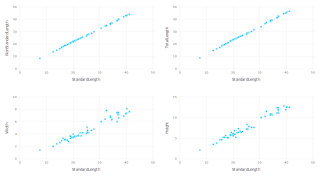

In [16]:
Gadfly.set_default_plot_size(32cm, 18cm)
fig1 = plot(perche, x=:StandardLength, y=:NonStandardLength, Geom.point)
fig2 = plot(perche, x=:StandardLength, y=:TotalLength, Geom.point)
fig3 = plot(perche, x=:StandardLength, y=:Width, Geom.point)
fig4 = plot(perche, x=:StandardLength, y=:Height, Geom.point)

gridstack([fig1 fig2; fig3 fig4])

## c) Sélection d'un sous-ensemble des variables explicatives 

Sélectionnez un sous-ensemble des variables explicatives pour lequel il n'y a pas de multicolinéarité.

Toutes les variables explicatives sont toutes liées linéairement entre elles. Pour éviter la multicolinéarité, il faut choisir une seule variable.

## c)  Identification du meilleur modèle de régression linéaire simple

Puisqu'il y a présence de multicolinéarité entre toutes les variables, on cherche le meilleur modèle unidimensionnel. Utilisez le critère de votre choix pour l'identifier.

**Suggestion :** Vous pouvez transformer la variable d'intérêt pour trouver le meilleur modèle linéaire unidimensionnel.

In [17]:
varnames = [:StandardLength, :NonStandardLength, :TotalLength, :Height, :Width]

perche[!,:Weight_csquared] = (perche[:,:Weight]).^(1/3)

y = perche.Weight_csquared

n = length(y)

SST = sum( (y .- mean(y)).^2 )

res = DataFrame(Variable = Symbol[], R² = Float64[])

for varname in varnames
   
    X = hcat(ones(n), perche[:,varname])
    β̂ = X\y
    
    e = y - X*β̂
    SSE = e'e
    
    push!(res, [varname, 1-SSE/SST])
    
end

sort!(res, :R², rev=true)

5×2 DataFrame
 Row │ Variable           R²       
     │ Symbol             Float64  
─────┼─────────────────────────────
   1 │ TotalLength        0.985082
   2 │ Height             0.984836
   3 │ NonStandardLength  0.984586
   4 │ StandardLength     0.984345
   5 │ Width              0.972004

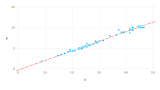

In [18]:
x = perche[:,res.Variable[1]]
y = perche.Weight_csquared

n = length(y)

X = hcat(ones(n), x)

β̂ = X\y

Gadfly.set_default_plot_size(16cm, 9cm)
plot(x=x, y=y, Geom.point, intercept = [β̂[1]], slope = [β̂[2]], Geom.abline(color="red", style=:dash))

## d) Vérification des hypothèses de la régression

Vérifiez si les hypothèses 1 à 4 de la régression sont satisfaites. Pour ce faire, tracer les graphiques suivants :
- le nuage des points {(ŷᵢ, eᵢ) : 1 ≤ i ≤ n} pour vérifier les hypothèses 1 et 2
- la droite de Henry pour vérifier l'hypothèse 4.

**Suggestion :** Vous pouvez utiliser la fonction `henryplot()` fournie pour tracer le diagramme quantile-quantile entre la loi normale et les résidus.


In [19]:
function henryplot(y::Vector{<:Real})

    n = length(y)
    ysorted = sort(y)

    p = ( collect(1:n) .- .5 ) /n

    fd = fit(Normal,y)

    q = quantile.(fd,p)

    plot(x=ysorted, y=q, Geom.point,
    Guide.xlabel("Empirical quantiles"), Guide.ylabel("Estimated quantiles"),
    Theme(discrete_highlight_color=c->nothing),
    Geom.abline(color="red"))


end

henryplot (generic function with 1 method)

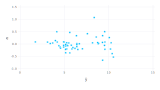

In [20]:
ŷ = X*β̂
e = y - ŷ

Gadfly.set_default_plot_size(16cm, 9cm)
plot(x=ŷ, y=e, Geom.point, Guide.xlabel("ŷ"), Guide.ylabel("e"))

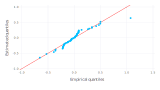

In [21]:
henryplot(e)

## e) Relation pour les poids originaux

Tracez le nuage de points illustrant les poids originaux des perches (dans le cas où vous auriez fait une transformation) en fonction votre variable explicative ainsi que la relation obtenue.

**Suggestion :** Utilisez la fonction `layer()` pour superposer plusieurs couches sur un graphique.

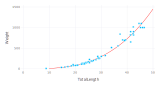

In [22]:
xx = collect(range(10, stop=50, length=1000))
yy = (β̂[1] .+ β̂[2]*xx).^3

obs = layer(perche, x=res.Variable[1], y=:Weight, Geom.point)
model = layer(x=xx, y=yy, Geom.line, Theme(default_color="red"))

Gadfly.set_default_plot_size(16cm, 9cm)
plot(obs, model)

# Exercice 4 : Recherche du meilleur modèle possible

Dans cet exercice, on cherche le meilleur modèle pour prédire le poids de perches. J'ai l'impression que les modèles suivants pourraient être pertinents :
- X = StandardLength * Width * Height (on suppose que le poisson est de la forme d'un prisme rectangulaire)
- X = StandardLength * Width^2 (on suppose que le poisson est un cylindre)
- etc.

C'est votre travail de créer de nouvelles variables explicatives à partir de celle que vous avez pour rechercher le meilleur modèle possible.

In [23]:
perche = filter(row -> row.Species == "Perche", data)

perche.Volume = perche.StandardLength .* perche.Width .* perche.Height

n = size(perche,1)

X = hcat(ones(n), perche.Volume)

β̂ = X\perche.Weight

ŷ = X*β̂

e = perche.Weight - ŷ

SSE = e'e
SST = sum( (perche.Weight .- mean(perche.Weight)).^2 )

R² = 1 - SSE/SST

0.9859933724705562

Je ne sais pas si c'est le meilleur modèle possible mais c'est un bon.